In [ ]:
import tensorflow as tf

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add, ELU, LeakyReLU
from keras.models import Model, model_from_json
from keras.optimizers import Adam
# from keras.layers.advanced_activations import ELU, LeakyReLU
from tensorflow.keras.utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
import matplotlib.image as img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the Images


In [ ]:
img_files = next(os.walk('/content/drive/MyDrive/Sorghum Disease Image Dataset/Rust'))[2]
msk_files = next(os.walk('/content/drive/MyDrive/Rust_mask'))[2]

img_files.sort()
msk_files.sort()

print(len(img_files))
print(len(msk_files))

2192
2192


In [ ]:
img_files[0]

'Rust1.jpg'

In [ ]:
msk_files[0]

'Rust1.png'

In [ ]:
X = []
Y = []

for img_fl in tqdm(img_files):
    if(img_fl.split('.')[-1]=='jpg'):


        img = cv2.imread('/content/drive/MyDrive/Sorghum Disease Image Dataset/Rust/{}'.format(img_fl), cv2.IMREAD_COLOR)
        resized_img = cv2.resize(img,(256, 192), interpolation = cv2.INTER_CUBIC)

        X.append(resized_img)

        msk_fl = img_fl.replace('.jpg', '.png')
        msk = cv2.imread('/content/drive/MyDrive/Rust_mask/{}'.format(msk_fl), cv2.IMREAD_GRAYSCALE)
        resized_msk = cv2.resize(msk,(256, 192), interpolation = cv2.INTER_CUBIC)

        Y.append(resized_msk)

100%|██████████| 2192/2192 [33:48<00:00,  1.08it/s]


## Train-Test Split


In [ ]:
print(len(X))
print(len(Y))

X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1))

X_train = X_train / 255
X_test = X_test / 255
Y_train = Y_train / 255
Y_test = Y_test / 255

Y_train = np.round(Y_train,0)
Y_test = np.round(Y_test,0)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


2192
2192
(1753, 192, 256, 3)
(1753, 192, 256, 1)
(439, 192, 256, 3)
(439, 192, 256, 1)


# MultiResUNet Model

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


## Auxiliary Functions

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection / union

In [ ]:
def saveModel(model):

    model_json = model.to_json()

    try:
        os.makedirs('/content/drive/MyDrive/models')
    except:
        pass

    fp = open('/content/drive/MyDrive/models/modelP.json','w')
    fp.write(model_json)
    model.save_weights('/content/drive/MyDrive/models/modelW.weights.h5')


In [ ]:
def evaluateModel(model, X_test, Y_test, batchSize):

    try:
        os.makedirs('results')
    except:
        pass


    yp = model.predict(x=X_test, batch_size=batchSize, verbose=1)

    yp = np.round(yp,0)

    for i in range(10):

        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.imshow(X_test[i])
        plt.title('Input')
        plt.subplot(1,3,2)
        plt.imshow(Y_test[i].reshape(Y_test[i].shape[0],Y_test[i].shape[1]))
        plt.title('Ground Truth')
        plt.subplot(1,3,3)
        plt.imshow(yp[i].reshape(yp[i].shape[0],yp[i].shape[1]))
        plt.title('Prediction')

        intersection = yp[i].ravel() * Y_test[i].ravel()
        union = yp[i].ravel() + Y_test[i].ravel() - intersection

        jacard = (np.sum(intersection)/np.sum(union))
        plt.suptitle('Jacard Index'+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +'='+str(jacard))

        plt.savefig('results/'+str(i)+'.png',format='png')
        plt.close()


    jacard = 0
    dice = 0


    for i in range(len(Y_test)):
        yp_2 = yp[i].ravel()
        y2 = Y_test[i].ravel()

        intersection = yp_2 * y2
        union = yp_2 + y2 - intersection

        jacard += (np.sum(intersection)/np.sum(union))

        dice += (2. * np.sum(intersection) ) / (np.sum(yp_2) + np.sum(y2))


    jacard /= len(Y_test)
    dice /= len(Y_test)



    print('Jacard Index : '+str(jacard))
    print('Dice Coefficient : '+str(dice))


    fp = open('/content/drive/MyDrive/models/log.txt','a')
    fp.write(str(jacard)+'\n')
    fp.close()

    fp = open('/content/drive/MyDrive/models/best.txt','r')
    best = fp.read()
    fp.close()

    if(jacard>float(best)):
        print('***********************************************')
        print('Jacard Index improved from '+str(best)+' to '+str(jacard))
        print('***********************************************')
        fp = open('/content/drive/MyDrive/models/best.txt','w')
        fp.write(str(jacard))
        fp.close()

        saveModel(model)


In [ ]:
def trainStep(model, X_train, Y_train, X_test, Y_test, epochs, batchSize):


    for epoch in range(epochs):
        print('Epoch : {}'.format(epoch+1))
        model.fit(x=[X_train], y=[Y_train], batch_size=batchSize, epochs=1, verbose=1)

        evaluateModel(model,X_test, Y_test,batchSize)

    return model

## Define Model, Train and Evaluate

In [ ]:
model = MultiResUnet(height=192, width=256, n_channels=3)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, jacard, 'accuracy'])

saveModel(model)

fp = open('/content/drive/MyDrive/models/log.txt','w')
fp.close()
fp = open('/content/drive/MyDrive/models/best.txt','w')
fp.write('-1.0')
fp.close()

# model.fit(x=[X_train], y=[Y_train], batch_size=10, epochs=10, callbacks=[early_stopping])

In [ ]:
trainStep(model, X_train, Y_train, X_test, Y_test, epochs=10, batchSize=10)

Epoch : 1
176/176 ━━━━━━━━━━━━━━━━━━━━ 186s 581ms/step - accuracy: 0.8427 - dice_coef: 0.4159 - jacard: 0.2662 - loss: 0.5216


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(10, 192, 256, 3))
  warnings.warn(msg)


43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 192, 256, 3))
  warnings.warn(msg)


44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 409ms/step
Jacard Index : 0.15814727551453375
Dice Coefficient : 0.2546467462613506
***********************************************
Jacard Index improved from -1.0 to 0.15814727551453375
***********************************************
Epoch : 2
176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 368ms/step - accuracy: 0.9237 - dice_coef: 0.4545 - jacard: 0.2972 - loss: 0.4251
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step
Jacard Index : 0.3484954922812992
Dice Coefficient : 0.4871655915456415
***********************************************
Jacard Index improved from 0.15814727551453375 to 0.3484954922812992
***********************************************
Epoch : 3
176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 370ms/step - accuracy: 0.9337 - dice_coef: 0.4770 - jacard: 0.3161 - loss: 0.3817
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step
Jacard Index : 0.5757575987800413
Dice Coefficient : 0.7150752510826602
***********************************************
Jacard Index improved from 0.3484954922812992 t

<Functional name=functional, built=True>

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


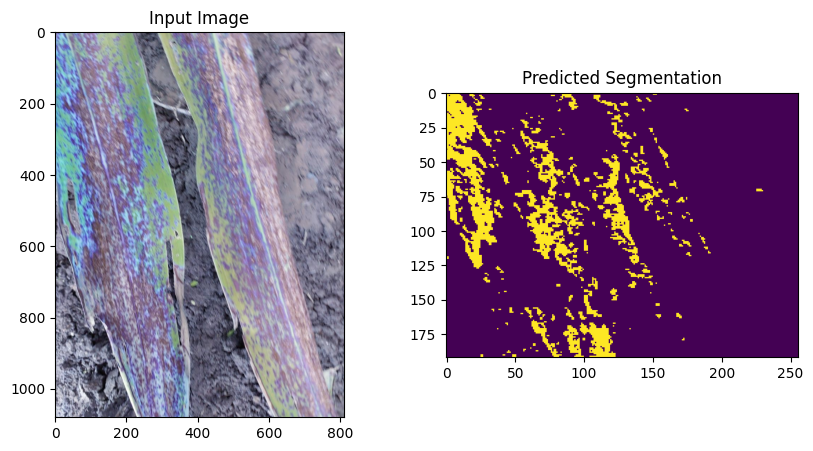

In [ ]:
import tensorflow as tf
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json


def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


def jacard(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection / union


# Load the model architecture from JSON file
with open('/content/drive/MyDrive/models/modelP.json', 'r') as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json, custom_objects={'dice_coef': dice_coef, 'jacard': jacard})

# Load the model weights
model.load_weights('/content/drive/MyDrive/models/modelW.weights.h5')

# Function to predict on a single image
def predict_image(img_path):
  """Predicts the segmentation mask for a given image.

  Args:
    img_path: Path to the input image.

  Returns:
    The predicted segmentation mask.
  """
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  resized_img = cv2.resize(img, (256, 192), interpolation=cv2.INTER_CUBIC)
  input_img = resized_img / 255  # Normalize the image
  input_img = np.expand_dims(input_img, axis=0)  # Add batch dimension

  prediction = model.predict(input_img)[0]
  prediction = np.round(prediction, 0)  # Round to 0 or 1

  return prediction

# Upload an image from the user
# uploaded = files.upload()
img_path = '/content/drive/MyDrive/Sorghum Disease Image Dataset/Rust/Rust530.jpg'

# Make prediction
prediction = predict_image(img_path)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(img_path))
plt.title('Input Image')
plt.subplot(1, 2, 2)
plt.imshow(prediction.reshape(prediction.shape[0], prediction.shape[1]))
plt.title('Predicted Segmentation')
plt.show()

In [ ]:
from google.colab.patches import cv2_imshow

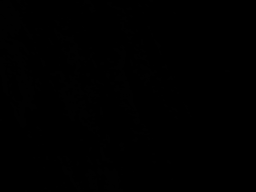

In [ ]:
cv2_imshow(prediction.reshape(prediction.shape[0], prediction.shape[1]))

In [ ]:
m = plt.imread('/content/drive/MyDrive/Rust_mask/Rust530.png')
i = plt.imread(img_path)

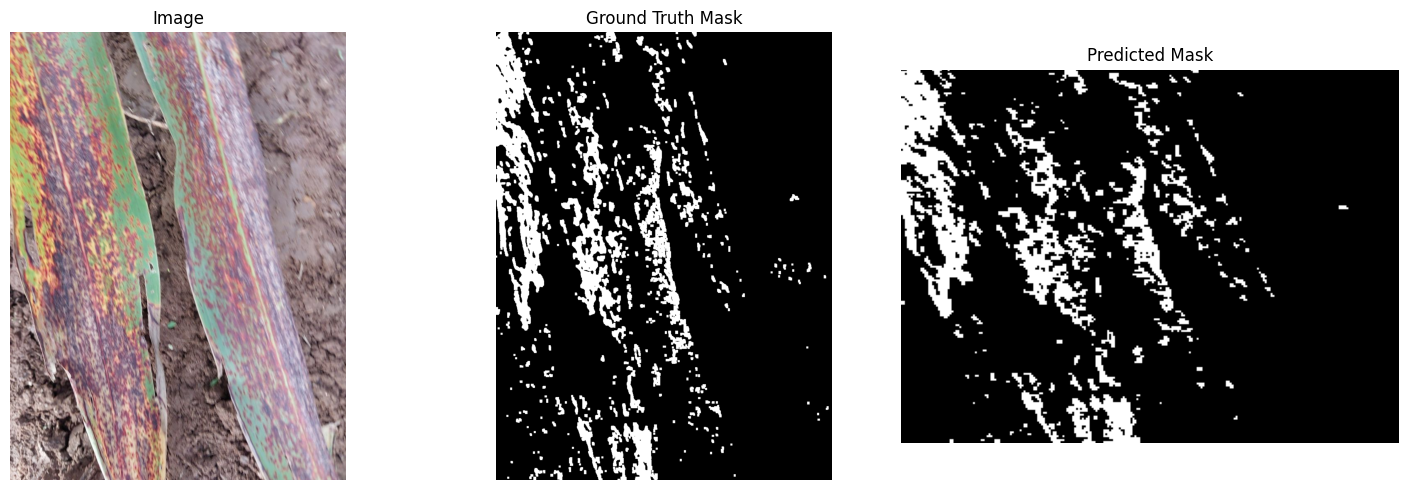

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(i)
axes[0].set_title('Image')

axes[1].imshow(m, cmap='gray')
axes[1].set_title('Ground Truth Mask')

axes[2].imshow(prediction.reshape(prediction.shape[0], prediction.shape[1]), cmap='gray')
axes[2].set_title('Predicted Mask')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import time
import tensorflow as tf

# ===== 1️⃣ Trainable Parameters (Million) =====
params = model.count_params() / 1e6  # Convert to million
print(f"Trainable Parameters: {params:.2f}M")

# ===== 2️⃣ Model Size (MB) =====
model.save("multiresunet_model.h5")  # Save the model
size_mb = os.path.getsize("multiresunet_model.h5") / (1024 * 1024)  # Convert bytes to MB
print(f"Model Size: {size_mb:.2f} MB")


Trainable Parameters: 7.26M
Model Size: 83.84 MB


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 192, 256, 8)    │            216 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 192, 256, 8)    │             24 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 192, 256, 8)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 192, 256, 17)   │          1,224 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 192, 256, 17)   │             51 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 192, 256, 17)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 192, 256, 26)   │          3,978 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 192, 256, 26)   │             78 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 192, 256, 26)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 192, 256, 51)   │            153 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192, 256, 51)   │              0 │ activation[0][0],      │
│                           │                        │                │ activation_1[0][0],    │
│                           │                        │                │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 192, 256, 51)   │            153 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 192, 256, 51)   │            204 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 192, 256, 51)   │              0 │ batch_normalization[0… │
│                           │                        │                │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activat

 Total params: 21,739,208 (82.93 MB)

 Trainable params: 7,238,228 (27.61 MB)

 Non-trainable params: 24,522 (95.79 KB)

 Optimizer params: 14,476,458 (55.22 MB)

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)